In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
data = np.loadtxt(open('../00-Dataset/mnist_train_small.csv', 'rb'), delimiter=',')

In [3]:
data.shape
labels = data[:,0]
data = data[:,1:]


In [4]:
# normalize the data to a range of [0, 1]
dataNorm = data/np.max(data)

In [5]:
dataNorm.shape

(20000, 784)

### Binarize the data

In [10]:
binaryData = np.where(dataNorm > 0, 1, 0)

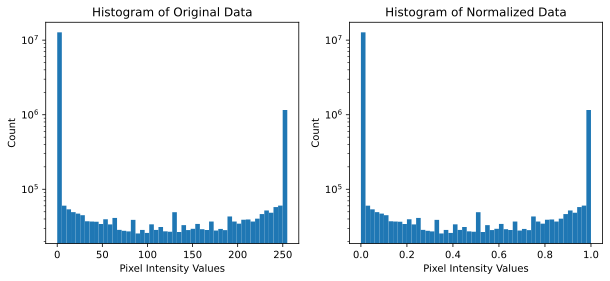

In [33]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel Intensity Values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of Original Data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel Intensity Values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Normalized Data')
ax[1].set_yscale('log')
plt.show()

In [11]:
# convert data to tensor
dataT = torch.tensor(binaryData).float()
labelsT = torch.tensor(labels).long() # long = int64

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, train_size = 0.9)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchSize = 32
train_loader = DataLoader(train_data, batch_size=batchSize, drop_last=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__())


In [12]:
%whos

Variable            Type             Data/Info
----------------------------------------------
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
F                   module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
batchSize           int              32
binaryData          ndarray          20000x784: 15680000 elems, type `int64`, 125440000 bytes (119.62890625 Mb)
data                ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm            ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT               Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
labels              ndarray          20000: 20000 elems, type `float64`, 160000 bytes (156.25 kb)
labelsT             Tensor           tensor([6, 5, 7,  ..., 2, 9, 5])


In [13]:
class Model(nn.Module):
    def __init__ (self):
        super().__init__()

        self.input = nn.Linear(784, 64)
        self.h1 = nn.Linear(64, 32)
        self.h2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = torch.log_softmax(self.output(x), axis=1)
        # log_softmax() because of NLLLoss instead of CrossEntropyLoss

        return x

In [14]:
def getModel():
    ANN = Model()
    lossFunction = nn.NLLLoss()
    optimizer = torch.optim.SGD(params=ANN.parameters(), lr=0.01)

    return ANN, lossFunction, optimizer

In [15]:
# test above function/class
ANN, lossFunction, optimizer = getModel()

X, y = next(iter(train_loader))

yHat = ANN(X)
print(yHat) # these are the log of probabilities that the model outputs. Log, beacuse of log_softmax()
print(torch.exp(yHat)) # undoing the log. These will be between 0 and 1



tensor([[-2.3397, -2.3314, -2.3538, -2.3418, -2.2302, -2.4798, -2.1676, -2.2535,
         -2.3019, -2.2587],
        [-2.3609, -2.3127, -2.3317, -2.3447, -2.2271, -2.5077, -2.1581, -2.2603,
         -2.2957, -2.2651],
        [-2.3653, -2.3497, -2.3479, -2.3443, -2.2521, -2.4650, -2.1371, -2.2322,
         -2.3007, -2.2678],
        [-2.3461, -2.3248, -2.3429, -2.3645, -2.2131, -2.4742, -2.1791, -2.2493,
         -2.3149, -2.2497],
        [-2.3743, -2.3473, -2.3432, -2.3848, -2.2323, -2.4652, -2.1390, -2.2203,
         -2.3047, -2.2561],
        [-2.3370, -2.3347, -2.3601, -2.3456, -2.2172, -2.4793, -2.1764, -2.2439,
         -2.3118, -2.2533],
        [-2.3557, -2.3701, -2.3634, -2.3764, -2.2310, -2.4334, -2.1531, -2.2063,
         -2.3035, -2.2690],
        [-2.3697, -2.3580, -2.3452, -2.3601, -2.2487, -2.4590, -2.1358, -2.2276,
         -2.2929, -2.2666],
        [-2.3669, -2.3598, -2.3546, -2.3509, -2.2626, -2.4406, -2.1353, -2.2303,
         -2.2858, -2.2733],
        [-2.3472, -

In [16]:
def trainModel(ANN, lossFunction, optimizer):
    epochs = 60

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = ANN.forward(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        X, Y = next(iter(test_loader))

        with torch.no_grad():
            pred = ANN(X)

        testAcc.append(torch.mean((torch.argmax(pred, axis=1)==Y).float())*100)

    return trainAcc, testAcc, losses, ANN

In [17]:
ANN, lossFunction, optimizer = getModel()
trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer)

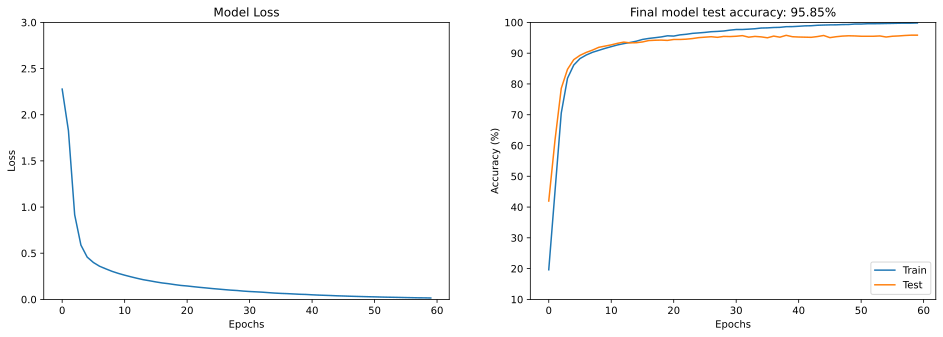

In [18]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')
ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

## Inspect the result in more details

In [19]:
X, Y = next(iter(test_loader))

with torch.no_grad():
    predictions = ANN(X).detach()

predictions

tensor([[-8.1322e-03, -3.2119e+01, -1.7819e+01,  ..., -2.0302e+01,
         -8.1404e+00, -4.8906e+00],
        [-3.3659e-04, -2.0025e+01, -8.6933e+00,  ..., -1.7488e+01,
         -1.2734e+01, -2.0418e+01],
        [-2.2748e+01, -2.3449e+01, -1.1921e-06,  ..., -1.3689e+01,
         -2.3114e+01, -3.3439e+01],
        ...,
        [-8.0214e+00, -1.3353e+01, -1.6574e+01,  ..., -1.5764e+01,
         -9.2998e+00, -1.2929e+01],
        [-3.2679e+01, -2.4060e+01,  0.0000e+00,  ..., -2.4816e+01,
         -2.2119e+01, -4.4606e+01],
        [-1.5106e+01, -1.4668e+01, -1.2691e+01,  ..., -1.9105e+01,
         -1.0490e-05, -1.1990e+01]])

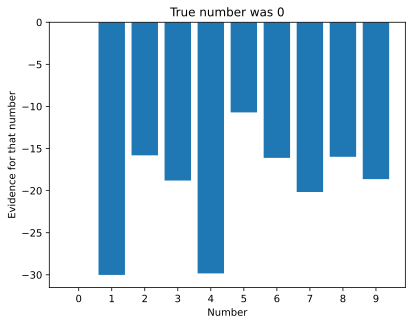

In [20]:
sample2test = 122
plt.bar(range(10), predictions[sample2test])
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %Y[sample2test].item())
plt.show()

# log of 1 is 0 so the correct prob is close to zero

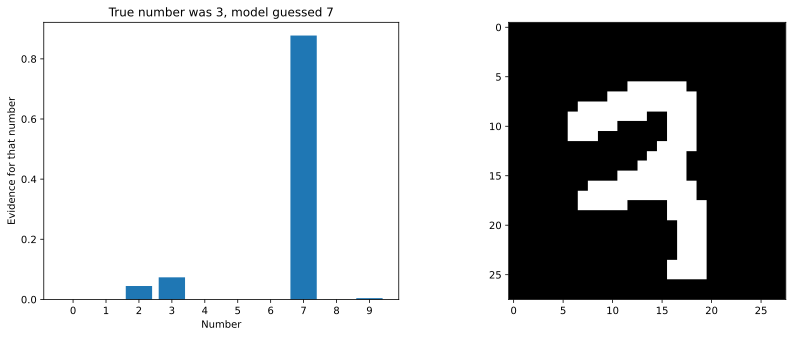

In [23]:
# find the errors

errors = np.where(torch.argmax(predictions, axis=1)!=Y)[0]

sample2test = 39

fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].bar(range(10), np.exp(predictions[errors[sample2test]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number was %s, model guessed %s' %(Y[errors[sample2test]].item(), 
                torch.argmax(predictions[errors[sample2test]]).item()))
ax[1].imshow(np.reshape(X[errors[sample2test],:], (28, 28)), cmap = 'gray')
plt.show()